# Trabajo Práctico 2: Entrenamiento y evaluación de modelos

## Integrantes: Cravero, Ulises y Pautasso, L. Nicolás.
## Tema: CS:GO Professional Matches.

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import sqlite3
import opendatasets as od
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
pd.options.display.max_columns = None
# dataset resultante del tp1
players = pd.read_csv('players_mejor_3.csv')

## Descarga de datasets:

#### Descargamos e instanciamos las variables de manera que no haya que ejecutar el paso a paso del notebook y solo exista a modo explicativo.

In [ ]:
# descargamos los datasets correspondientes desde Kaggle
od.download("https://www.kaggle.com/nicopautasso31/csgo-players-maps-performance")

In [ ]:
# instanciamos las variables
players_nuevo = pd.read_csv('csgo-players-maps-performance/players_preprocesado_sin_fe.csv')
players_nuevo_fe = pd.read_csv('csgo-players-maps-performance/players_preprocesado_con_fe.csv')
players_nuevo_sin_paises = pd.read_csv('csgo-players-maps-performance/players_preprocesado_sin_paises.csv')

print('Variables creadas. Se puede dirigir directamente a la seccion "Definición de métricas" y continuar la ejecución')

## Preprocesamiento de nuestro dataset

In [14]:
# nos quedamos solo con los registros que se jugaron al mejor de 3 mapas
players = players[players["best_of"] == 3]

In [15]:
# borramos las columnas correspondientes a variables que se encuentran desagregadas por mapa y las de resumen del partido total
players.drop(columns=['m1_kills', 'm1_assists', 'm1_deaths', 'm2_kills', 'm2_assists', 'm2_deaths', 'm3_kills', 'm3_assists', 'm3_deaths', 'kills', 'assists', 'deaths', 'hs', 'flash_assists', 'kast', 'adr', 'fkdiff', 'rating','kills_ct', 'deaths_ct', 'kddiff_ct', 'adr_ct','kast_ct','rating_ct','kills_t','deaths_t','kddiff_t','adr_t','kast_t','rating_t', 'kddiff','m1_kills_ct','m1_deaths_ct','m1_kddiff_ct','m1_adr_ct','m1_kast_ct','m1_rating_ct','m1_kills_t','m1_deaths_t','m1_kddiff_t','m1_adr_t','m1_kast_t','m1_rating_t','m2_kills_ct','m2_deaths_ct','m2_kddiff_ct','m2_adr_ct','m2_kast_ct','m2_rating_ct','m2_kills_t','m2_deaths_t','m2_kddiff_t','m2_adr_t','m2_kast_t','m2_rating_t','m3_kills_ct','m3_deaths_ct','m3_kddiff_ct','m3_adr_ct','m3_kast_ct','m3_rating_ct','m3_kills_t','m3_deaths_t','m3_kddiff_t','m3_kast_t','m3_rating_t','m3_adr_t'],axis=1,inplace=True)

In [16]:
players.sample(3)

,date,player_name,team,opponent,country,player_id,match_id,event_id,event_name,best_of,map_1,map_2,map_3,m1_hs,m1_flash_assists,m1_kast,m1_kddiff,m1_adr,m1_fkdiff,m1_rating,m2_hs,m2_flash_assists,m2_kast,m2_kddiff,m2_adr,m2_fkdiff,m2_rating,m3_hs,m3_flash_assists,m3_kast,m3_kddiff,m3_adr,m3_fkdiff,m3_rating
130955,2017-08-03,goffe,30minuter,Snabbabrillor,Sweden,10782,2313225,3039,G:loot Cup Summer 2017 Qualifier 2,3,Overpass,Mirage,NaN,16,0.0,72.2,-3,77.9,-2,1.05,7.0,2.0,53.3,-8.0,54.8,0.0,0.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182777,2016-03-27,panda$ex,tNt,Cloud9,United States,11964,2301797,2197,DreamHack Austin 2016 Closed Qualifier,3,Cache,Cobblestone,NaN,5,NaN,70.6,-5,69.9,0,0.75,6.0,NaN,56.5,-7.0,75.3,-2.0,0.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84694,2018-06-25,gr3eps,Wildcats,Ex-Rejected,Chile,10820,2324215,3863,HyperX Defuse 2018,3,Cache,Dust2,NaN,9,0.0,66.7,-6,82.7,-1,0.93,7.0,NaN,58.6,-7.0,58.6,-3.0,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
players.shape

(178728, 34)

#### Como nuestro objetivo es predecir como resultará el kddiff en el próximo mapa, el nuevo dataset que utilizaremos para entrenar los modelos tendrá como registros la información organizada de forma que, en su mayoria, cada registro original califique para dos registros en el nuevo dataset.
##### Ejemplo: un registro el cual tenia información de tres mapas (m1, m2 y m3) pasará a convertirse en dos registros de la forma:
* Registro 1: first_map = m1 y second_map = m2
* Registro 2: first_map = m2 y second_map = m3

In [18]:
# creamos una conexión a una base de datos en memoria
conn = sqlite3.connect(":memory:")

# guardamos los datos en una tabla temporal
players.to_sql("players", conn, if_exists="replace")

# al armar el dataset nuevo descartamos las columnas que son ids (menos match_id que lo usamos despues para transformar team y opponent), date, player_name y event_name al no utilizarlas
# tambien borramos las columnas correspondientes a valores futuros al momento de predecir por lo que no debemos mantener en entre los datos
query = """
SELECT match_id, team, opponent, country, map_1 AS first_map, m1_hs AS first_map_hs, m1_kast AS first_map_kast, m1_kddiff AS first_map_kddiff, m1_adr AS first_map_adr,
    m1_fkdiff AS first_map_fkdiff, m1_rating AS first_map_rating, map_2 AS second_map, m2_kddiff AS second_map_kddiff
FROM players;
"""

#aca lo que hacemos es para no perder los registros que solo se jugaron dos mapas porque los ganaron de corrido
#si el map3 tiene NaN no creamos el segundo registro
query2 = """
SELECT match_id, team, opponent, country, map_2 AS first_map, m2_hs AS first_map_hs, m2_kast AS first_map_kast, m2_kddiff AS first_map_kddiff, m2_adr AS first_map_adr,
    m2_fkdiff AS first_map_fkdiff, m2_rating AS first_map_rating, map_3 AS second_map, m3_kddiff AS second_map_kddiff
FROM players
WHERE map_3 IS NOT NULL;
"""

# obtenemos un dataset con los registros de la primer query
players_nuevo_first = pd.read_sql_query(query, conn)
# obtenemos un dataset con los registros de la segunda query
players_nuevo_second = pd.read_sql_query(query2, conn)

conn.close()

# concatenamos ambos dataset para obtener el nuevo dataset final
players_nuevo = pd.concat([players_nuevo_first, players_nuevo_second], ignore_index=True)


In [19]:
players_nuevo.sample(3)

,match_id,team,opponent,country,first_map,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map,second_map_kddiff
177074,2298991,Refuse,Vega Squadron,Norway,Mirage,8.0,NaN,-1.0,NaN,-2.0,0.87,Cache,-2.0
211828,2322011,North,ALTERNATE aTTaX,Denmark,Cobblestone,8.0,75.0,0.0,79.6,0.0,1.16,Cache,10.0
59252,2329221,MIBR,Astralis,Brazil,Mirage,10.0,61.5,-1.0,67.5,1.0,0.86,Train,6.0


In [20]:
players_nuevo.shape

(244370, 13)

#### En lo que respecta a la utilización de One-Hot-Encoders, primero chequeamos cuantas columnas nuevas obtendríamos al aplicarlo y luego lo aplicamos

In [21]:
num_country = players_nuevo['country'].nunique()
num_first_map = players_nuevo['first_map'].nunique()
num_second_map = players_nuevo['second_map'].nunique()

# Imprimir la cantidad de valores distintos
print("Cantidad de valores distintos en la columna 'country':", num_country)
print("Cantidad de valores distintos en la columna 'first_map':", num_first_map)
print("Cantidad de valores distintos en la columna 'second_map':", num_second_map)

Cantidad de valores distintos en la columna 'country': 109
Cantidad de valores distintos en la columna 'first_map': 10
Cantidad de valores distintos en la columna 'second_map': 10


In [22]:
# hacer one hot enconder a country, first_map y second_map:
# creamos las columnas encodeadas y las formateamos
players_nuevo = pd.get_dummies(players_nuevo, columns=['country','first_map', 'second_map'])

players_nuevo.columns = players_nuevo.columns.str.lower()

# renombramos columnas que pertenecen a paises con nombres compuestos
BETTER_COLUMN_NAMES = {
    'country_bosnia and herzegovina': 'country_bosnia_and_herzegovina',
    'country_costa rica': 'country_costa_rica',
    'country_czech republic': 'country_czech_republic',
    'country_dominican republic': 'country_dominican_republic',
    'country_el salvador': 'country_el_salvador',
    'country_faroe islands': 'country_faroe_islands',
    'country_hong kong': 'country_hong_kong',
    'country_new zealand': 'country_new_zealand',
    'country_saudi arabia': 'country_saudi_arabia',
    'country_south africa': 'country_south_africa',
    'country_sri lanka': 'country_sri_lanka',
    'country_united arab emirates': 'country_united_arab_emirates',
    'country_united kingdom': 'country_united_kingdom',
    'country_united states': 'country_united_states'
}
players_nuevo.rename(columns=BETTER_COLUMN_NAMES, inplace=True)


In [23]:
players_nuevo.shape

(244370, 139)

#### En lo que respecta a la normalización de variables, aplicamos un Min-Max-Scaler a las columnas que tiene información en un rango amplio de números

In [24]:
# normalizamos todas las columnas necesarias
columnas_a_normalizar = ['first_map_hs','first_map_kast', 'first_map_kddiff', 'first_map_adr', 'first_map_fkdiff']

# Crear un objeto MinMaxScaler para normalizar las columnas
scaler = preprocessing.MinMaxScaler()

# Normalizar las columnas seleccionadas
players_nuevo[columnas_a_normalizar] = scaler.fit_transform(players_nuevo[columnas_a_normalizar])



#### Ahora convertimos nuestra variable de salida 'second_map_kddiff' en las etiquetas 1 o 0 dependiendo si son positivas o negativas, respectivamente.

In [25]:
players_nuevo['second_map_kddiff'] = np.where(players_nuevo['second_map_kddiff'] >= 0, 1, 0)

players_nuevo.sample(3)

,match_id,team,opponent,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo
188497,2335511,HAVU,Gambit Youngsters,0.263158,0.675906,0.250000,0.279629,0.44,0.79,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
32042,2334356,G2,NRG,0.263158,0.619403,0.400000,0.422174,0.44,1.00,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,F

#### Por último, borramos registros que contengan valores nulos en alguna columna que puedan afectar a nuestro entrenamiento

In [26]:
# borramos los registros de players_nuevo que quedan con valores en alguna columna
indices_a_eliminar = []
for index, registro in players_nuevo.iterrows():
    # Verifica si las columnas seleccionadas contienen el valor -1
    if registro.isnull().any():
        # guardamos el indice para eliminarlo despues
        indices_a_eliminar.append(index)

# Elimina los registros en un solo paso
players_nuevo.drop(indices_a_eliminar, inplace=True)

In [27]:
#chequeamos valores nulos
players_nuevo.isnull().sum()

match_id               0
team                   0
opponent               0
first_map_hs           0
first_map_kast         0
                      ..
second_map_mirage      0
second_map_nuke        0
second_map_overpass    0
second_map_train       0
second_map_vertigo     0
Length: 139, dtype: int64

##### Dataset checkpoint:

In [10]:
# guardamos el dataset que nos servirá como checkpoint para hacerle luego la feature engineering (mantenemos columnas team, opponent y match_id que necesitaremos luego para procesar)
# players_nuevo.to_csv('players_preprocesado_checkpoint.csv', index=False)

#### Finalizado el preprocesamiento del dataset, sin Feature Engineering

In [8]:
#borramos luego las columnas match_id, team y opponent que no vamos a utilizar en los primeros entrenamientos
players_nuevo.drop(columns=['team', 'opponent', 'match_id'],axis=1,inplace=True)
#players_nuevo.to_csv('players_preprocesado_sin_fe.csv', index=False)        
players_nuevo.sample(3)

,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo
18836,0.157895,0.608742,0.400000,0.428727,0.44,0.98,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
53250,0.263158,0.695096,0.633333,0.492081,0.60,1.42,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
81028,0.105263,0.775053,0.533333,0.4

##### Dataset extra: se armó un dataset en el que no se utiliza las variables de los paises, reduciendo su dimensionalidad.

In [9]:
#prefix = 'country_'
#columns_to_drop = [col for col in players_nuevo.columns if col.startswith(prefix)]
#players_nuevo_sin_paises = players_nuevo.drop(columns=columns_to_drop)

#players_nuevo_sin_paises.to_csv('players_preprocesado_sin_paises.csv', index=False)

players_nuevo_sin_paises.sample(3)

# también disponible en el conjunto de datasets que se descarga al inicio del notebook e inicializado en la variable 'players_nuevo_sin_paises'

,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo
52684,0.026316,0.348614,0.216667,0.197706,0.32,0.27,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
159666,0.236842,0.861407,0.633333,0.448935,0.52,1.50,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
200547,0.052632,0.723881,0.483333,0.430366,0.64,1.24,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False


## Feature engineering del dataset

### Codificación de variables team y opponent como el puesto que ocupaba cada equipo en el ranking profesional oficial de CS:Go en el día del partido

##### Para esto utilizamos el dataset results.csv del mismo lugar donde descargamos el dataset que estamos utilizando.
##### Lo que hacemos es por cada match_id, reemplazar las columnas team y opponent del dataset actual por el número del puesto del ranking del otro dataset, generando nuevas columnas (team_ranking y opponent_ranking)

In [31]:
# leemos el dataset que establecimos como checkpoint antes de realizar feature engineering y que se descargo al iniciar el notebook
players_nuevo_fe = pd.read_csv('csgo-players-maps-performance/players_preprocesado_checkpoint.csv')

In [32]:
players_nuevo_fe.sample(3)

,match_id,team,opponent,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo
152610,2304422,Dignitas,Astralis,0.236842,0.605544,0.633333,0.570726,0.52,1.51,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
170489,2300273,G2,CyberZen,0.157895,0.369936,0.300000,0.295467,0.52,0.59,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,F

#### Este dataset contiene tres registros por cada partido (el resultado de cada mapa), por lo que lo leemos y nos quedamos con cualquier de esos tres registros, ya que solo nos interesa el ranking y son los mismos valores en los tres.


In [33]:
results = pd.read_csv('results.csv').drop_duplicates(subset='match_id', keep='first')

results.sample(1)

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
785,2020-02-25,Renegades,FaZe,Inferno,12,16,2,2,5,8,7,8,4901,2339387,24,9,0,2,2


#### Creamos las columnas nuevas que van a alojar el valor de ranking y las asignamos

In [34]:
players_nuevo_fe["team_ranking"] = -1
players_nuevo_fe["opponent_ranking"] = -1

#recorremos players_nuevo_fe
for index, registro in players_nuevo_fe.iterrows():
    #buscamos el registro de results que coincida con el actual match_id del registro de players_nuevo_fe
    row = results.loc[results['match_id'] == registro['match_id']]
    #si encontramos el match en results
    if len(row) > 0:
        #asignamos las nuevas columnas del ranking de cada equipo dependiendo como venian ordenadas
        if registro['team'] == row['team_1'].values[0] and registro['opponent'] == row['team_2'].values[0]:
            players_nuevo_fe.loc[index, 'team_ranking'] = row['rank_1'].values[0]
            players_nuevo_fe.loc[index, 'opponent_ranking'] = row['rank_2'].values[0]
        elif registro['opponent'] == row['team_1'].values[0] and registro['team'] == row['team_2'].values[0]:
            players_nuevo_fe.loc[index, 'team_ranking'] = row['rank_2'].values[0]
            players_nuevo_fe.loc[index, 'opponent_ranking'] = row['rank_1'].values[0]

players_nuevo_fe.sample(3)

,match_id,team,opponent,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo,team_ranking,opponent_ranking
66141,2327287,skipping school,Imperial,0.210526,0.657783,0.300000,0.330967,0.44,0.80,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,-1,-1
142730,2307063,SK,Immortals,0.289474,0.658849,0.516667,0.474604,0.56,1.32,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False

#### Borramos los registros de players_nuevo_fe que mantienen las columnas nuevas en -1. Esto quiere decir que no tenian ocurrencia en results, resultando en la perdiendo de algunos registros del dataset original.

In [35]:
indices_a_eliminar = []
for index, registro in players_nuevo_fe.iterrows():
    # Verifica si las columnas seleccionadas contienen el valor -1
    if registro['team_ranking'] == -1 or registro['opponent_ranking'] == -1:
        # guardamos el indice para eliminarlo despues
        indices_a_eliminar.append(index)

# Elimina los registros en un solo paso
players_nuevo_fe.drop(indices_a_eliminar, inplace=True)

#borramos tambien las columnas match_id, team y opponent que ya no utilizamos
players_nuevo_fe.drop(columns=['team', 'opponent', 'match_id'],axis=1,inplace=True)
        
players_nuevo_fe.sample(3)

,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,country_armenia,country_australia,country_austria,country_azerbaijan,country_bahrain,country_bangladesh,country_belarus,country_belgium,country_bolivia,country_bosnia_and_herzegovina,country_brazil,country_brunei,country_bulgaria,country_cambodia,country_canada,country_chile,country_china,country_colombia,country_costa_rica,country_croatia,country_cyprus,country_czech_republic,country_denmark,country_dominican_republic,country_ecuador,country_egypt,country_el_salvador,country_estonia,country_faroe_islands,country_finland,country_france,country_georgia,country_germany,country_greece,country_guatemala,country_hong_kong,country_hungary,country_iceland,country_india,country_indonesia,country_iran,country_iraq,country_ireland,country_israel,country_italy,country_japan,country_jordan,country_kazakhstan,country_korea,country_kuwait,country_kyrgyzstan,country_laos,country_latvia,country_lebanon,country_libya,country_lithuania,country_luxembourg,country_macau,country_macedonia,country_malaysia,country_malta,country_mexico,country_moldova,country_mongolia,country_montenegro,country_morocco,country_myanmar,country_nepal,country_netherlands,country_new_zealand,country_norway,country_pakistan,country_palestine,country_panama,country_paraguay,country_peru,country_philippines,country_poland,country_portugal,country_qatar,country_romania,country_russia,country_saudi_arabia,country_serbia,country_singapore,country_slovakia,country_slovenia,country_south_africa,country_spain,country_sri_lanka,country_sweden,country_switzerland,country_syria,country_taiwan,country_thailand,country_tunisia,country_turkey,country_turkmenistan,country_ukraine,country_united_arab_emirates,country_united_kingdom,country_united_states,country_uruguay,country_uzbekistan,country_venezuela,country_vietnam,first_map_cache,first_map_cobblestone,first_map_default,first_map_dust2,first_map_inferno,first_map_mirage,first_map_nuke,first_map_overpass,first_map_train,first_map_vertigo,second_map_cache,second_map_cobblestone,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo,team_ranking,opponent_ranking
32778,0.105263,0.675906,0.350000,0.372474,0.28,0.76,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,33,31
34413,0.342105,0.861407,0.733333,0.594211,0.40,1.75,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,

In [36]:
players_nuevo_fe.shape

(164211, 138)

#### Normalizamos todas las columnas necesarias

In [37]:
columnas_a_normalizar = ['team_ranking', 'opponent_ranking']

# creamos un objeto MinMaxScaler para normalizar las columnas
scaler = preprocessing.MinMaxScaler()

# normalizamos las columnas seleccionadas
players_nuevo_fe[columnas_a_normalizar] = scaler.fit_transform(players_nuevo_fe[columnas_a_normalizar])

#### Finalizado el preprocesamiento del dataset, con Feature Engineering

In [43]:
#players_nuevo_fe.to_csv('players_preprocesado_con_fe.csv', index=False)
players_nuevo_fe.sample(3)

,first_map_hs,first_map_kast,first_map_kddiff,first_map_adr,first_map_fkdiff,first_map_rating,second_map_kddiff,country_albania,country_algeria,country_argentina,...,second_map_default,second_map_dust2,second_map_inferno,second_map_mirage,second_map_nuke,second_map_overpass,second_map_train,second_map_vertigo,team_ranking,opponent_ranking
16990,0.131579,0.644989,0.466667,0.323867,0.44,1.02,1,False,False,False,...,False,True,False,False,False,False,False,False,0.353403,0.447644
47848,0.105263,0.763326,0.350000,0.429274,0.56,1.01,1,False,False,False,...,False,False,False,False,False,False,True,False,0.306283,0.675393
73915,0.342105,0.814499,0.516667,0.458766,0.56,1.32,1,False,False,False,...,False,False,False,True,False,False,False,False,0.094241,0.091623


In [39]:
players_nuevo_fe.shape

(164211, 138)

## Definición de métrica:

Elegimos ACCURACY (precisión).
La precisión es la proporción de predicciones correctas realizadas por el modelo. Se calcula dividiendo el número de predicciones correctas entre el número total de predicciones.
Elegimos esta métrica ya que es especialmente util en clasificación y además es fácil de interpretar.
Su desventaja principal se encuentra en problemas cuyas clases en el conjunto de datos están desbalanceadas, cosa que no presentará inconvenientes en nuestro dataset (valor obtenido en tp1 -> kddiff positivo = 50,07% / kddiff negativo = 49,03%)

## División del dataset:

### Sin feature engineering

In [10]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(players_nuevo, test_size=0.4, random_state=42)
validation, test = train_test_split(not_train, test_size=0.5, random_state=42)

train_y = train['second_map_kddiff']
train_x = train.drop(columns=['second_map_kddiff'])

validation_y = validation['second_map_kddiff']
validation_x = validation.drop(columns=['second_map_kddiff'])

test_y = test['second_map_kddiff']
test_x = test.drop(columns=['second_map_kddiff'])

# Mostramos las dimensiones finales de cada porcion del dataset
train_x.shape, train_y.shape, validation_x.shape, validation_y.shape, test_x.shape, test_y.shape




((140025, 135), (140025,), (46675, 135), (46675,), (46676, 135), (46676,))

### Con feature engineering

In [11]:
# 60% train, 20% test, 20% validation
train_fe, not_train_fe = train_test_split(players_nuevo_fe, test_size=0.4, random_state=42)
validation_fe, test_fe = train_test_split(not_train_fe, test_size=0.5, random_state=42)

train_y_fe = train_fe['second_map_kddiff']
train_x_fe = train_fe.drop(columns=['second_map_kddiff'])

validation_y_fe = validation_fe['second_map_kddiff']
validation_x_fe = validation_fe.drop(columns=['second_map_kddiff'])

test_y_fe = test_fe['second_map_kddiff']
test_x_fe = test_fe.drop(columns=['second_map_kddiff'])

# Mostramos las dimensiones finales de cada porcion del dataset
train_x_fe.shape, train_y_fe.shape, validation_x_fe.shape, validation_y_fe.shape, test_x_fe.shape, test_y_fe.shape

((98526, 137), (98526,), (32842, 137), (32842,), (32843, 137), (32843,))

## Entrenamiento de modelos:

### Regresion logística

In [12]:
# sin feature engineering
regression_model = LogisticRegression(random_state=42, max_iter=1000)
regression_model.fit(train_x, train_y)
y_pred = regression_model.predict(test_x)
print("Accuracy en test: " + str(metrics.accuracy_score(test_y, y_pred)))

# con feature engineering
regression_model_fe = LogisticRegression(random_state=42, max_iter=1000)
regression_model_fe.fit(train_x_fe, train_y_fe)
y_pred_fe = regression_model_fe.predict(test_x_fe)
print("Accuracy en test (con FE): " + str(metrics.accuracy_score(test_y_fe, y_pred_fe)))

Accuracy en test: 0.5775987659610935
Accuracy en test (con FE): 0.5876137989830406


### Random forest

In [13]:
# sin feature engineering
forest_model = RandomForestClassifier()
forest_model.fit(train_x, train_y)
y_pred = forest_model.predict(test_x)
print("Accuracy en test: " + str(metrics.accuracy_score(test_y, y_pred)))

# sin feature engineering
forest_model_fe = RandomForestClassifier()
forest_model_fe.fit(train_x_fe, train_y_fe)
y_pred_fe = forest_model_fe.predict(test_x_fe)


print("Accuracy en test (con FE): " + str(metrics.accuracy_score(test_y_fe, y_pred_fe)))

Accuracy en test: 0.5619590367640758
Accuracy en test (con FE): 0.5858782693420211


### K nearest neighbors (KNN)

In [14]:
#Parametros varios:
K = 5

# sin feature engineering
kkn_model = KNeighborsClassifier(n_neighbors=K)
kkn_model.fit(train_x, train_y)
y_pred = kkn_model.predict(test_x)
print("Accuracy en test: " + str(metrics.accuracy_score(test_y, y_pred)))

# con feature engineering
kkn_model_fe = KNeighborsClassifier(n_neighbors=K)
kkn_model_fe.fit(train_x_fe, train_y_fe)
y_pred_fe = kkn_model_fe.predict(test_x_fe)
print("Accuracy en test (con FE): " + str(metrics.accuracy_score(test_y_fe, y_pred_fe)))

Accuracy en test: 0.5372568343474162
Accuracy en test (con FE): 0.5444691410650672


### Dummie Classifier

In [15]:
from sklearn.dummy import DummyClassifier

# sin feature engineering
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(train_x, train_y)
y_pred = dummy_clf.predict(test_x)
print("Accuracy en test: " + str(metrics.accuracy_score(test_y, y_pred)))

# con feature engineering
dummy_clf_fe = DummyClassifier(strategy='uniform')
dummy_clf_fe.fit(train_x_fe, train_y_fe)
y_pred_fe = dummy_clf_fe.predict(test_x_fe)
print("Accuracy en test (con FE): " + str(metrics.accuracy_score(test_y_fe, y_pred_fe)))

Accuracy en test: 0.4984360270802982
Accuracy en test (con FE): 0.4996802971713912


## Definición de hiperparametros implementando GridSearch:

### Regresion logística

In [16]:
params = {
    'penalty': ['l2'],
    'C': [0.1, 1.0, 10.0]
}

lr_grid_search = GridSearchCV(regression_model_fe, params, cv=5)
lr_grid_search.fit(train_x_fe, train_y_fe)
y_pred_fe = lr_grid_search.predict(validation_x_fe)

print("Accuracy en validation: " + str(metrics.accuracy_score(validation_y_fe, y_pred_fe)))

print("Mejores parámetros encontrados:")
print(lr_grid_search.best_params_)
print("Puntuación media en el conjunto de validación:")
print(lr_grid_search.best_score_)

Accuracy en validation: 0.5823640460386091
Mejores parámetros encontrados:
{'C': 10.0, 'penalty': 'l2'}
Puntuación media en el conjunto de validación:
0.5856728365228179


### Random forest

In [17]:
params = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [5, 10, 15], 
    'max_features': ['sqrt', 'log2', 2, 5]
}

rf_grid_search = GridSearchCV(forest_model_fe, params, cv=5)
rf_grid_search.fit(train_x_fe, train_y_fe)
y_pred_fe = forest_model_fe.predict(validation_x_fe)

print("Accuracy en validation: " + str(metrics.accuracy_score(validation_y_fe, y_pred_fe)))

print("Mejores parámetros encontrados:")
print(rf_grid_search.best_params_)
print("Puntuación media en el conjunto de validación:")
print(rf_grid_search.best_score_)

Accuracy en validation: 0.5821813531453627
Mejores parámetros encontrados:
{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
Puntuación media en el conjunto de validación:
0.58203926622647


### K nearest neighbors (KNN)

In [18]:
params = {'n_neighbors': [3, 5, 7, 10, 15],
          'weights': ['uniform', 'distance'],
          'p': [1, 2]}

knn_grid_search = GridSearchCV(kkn_model_fe, params, cv=5)
knn_grid_search.fit(train_x_fe, train_y_fe)
y_pred_fe = knn_grid_search.predict(validation_x_fe)

print("Accuracy en validation: " + str(metrics.accuracy_score(validation_y_fe, y_pred_fe)))

print("Mejores parámetros encontrados:")
print(knn_grid_search.best_params_)
print("Puntuación media en el conjunto de validación:")
print(knn_grid_search.best_score_)

Accuracy en validation: 0.557700505450338
Mejores parámetros encontrados:
{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Puntuación media en el conjunto de validación:
0.5555792283074774


## Reducción de dimensionalidad
### Principal Component Analysis (PCA)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
# ajustamos PCA sobre el conjunto train
pca.fit(train_x_fe)

print("Importancias de las nuevas dimensiones:", pca.explained_variance_ratio_)  
# transformamos los demas conjuntos en base a lo obtenido
train_x_fe_pca = pca.transform(train_x_fe)
validation_x_fe_pca = pca.transform(validation_x_fe)
test_x_fe_pca = pca.transform(test_x_fe)

Importancias de las nuevas dimensiones: [0.07682108 0.06204394 0.05375131 0.04965411 0.04777203 0.04521689
 0.04280979 0.03960574 0.03827198 0.03628052]


### Regresion logística

In [20]:
# con feature engineering y PCA
regression_model_fe = LogisticRegression(random_state=42, max_iter=1000)
regression_model_fe.fit(train_x_fe_pca, train_y_fe)
y_pred_fe = regression_model_fe.predict(test_x_fe_pca)
print("Accuracy en test (con FE y PCA): " + str(metrics.accuracy_score(test_y_fe, y_pred_fe)))

Accuracy en test (con FE y PCA): 0.5611545839296045


### Random forest

In [21]:
# con feature engineering y PCA
forest_model_fe = RandomForestClassifier()
forest_model_fe.fit(train_x_fe_pca, train_y_fe)
y_pred_fe = forest_model_fe.predict(test_x_fe_pca)
print("Accuracy en test (con FE y PCA): " + str(metrics.accuracy_score(test_y_fe, y_pred_fe)))

Accuracy en test (con FE y PCA): 0.5360959717443595


### K nearest neighbors (KNN)

In [26]:
#Parametros varios:
K = 10

# con feature engineering y PCA
kkn_model_fe = KNeighborsClassifier(n_neighbors=K, p=1, weights='distance')
kkn_model_fe.fit(train_x_fe_pca, train_y_fe)
y_pred_fe = kkn_model_fe.predict(test_x_fe_pca)
print("Accuracy en test (con FE y PCA): " + str(metrics.accuracy_score(test_y_fe, y_pred_fe)))

Accuracy en test (con FE y PCA): 0.5316810279207137


## Diagramas de dispersión

### first_map_kddiff vs. first_map_rating

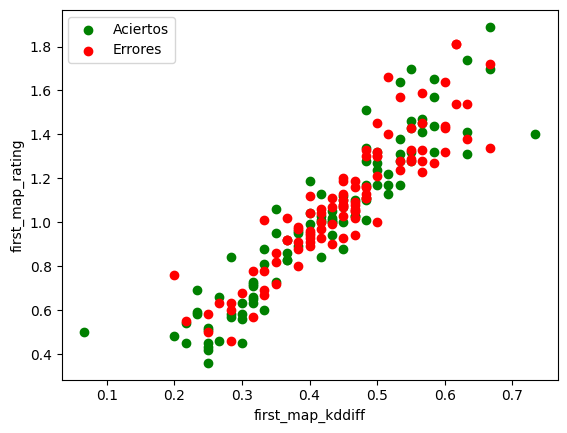

Existe una relación lineal entre esas dos variables y la variable objetivo. Además, si los datos de 'first_map_kddiff' y 'first_map_rating' toman valores ubicados cerca del promedio, es más probable que el modelo clasifique correctamente los casos aunque esto es una afirmación vaga ya que no hay un patrón claramente definido y las variables parecen no ser suficientes para distinguir claramente entre las clases.


In [27]:
variables = ['first_map_kddiff', 'first_map_rating']
regression_model_plot = LogisticRegression(random_state=42, max_iter=1000)
regression_model_plot.fit(train_x_fe[variables], train_y_fe)
y_pred_fe = regression_model_plot.predict(test_x_fe[variables])

df = test_x_fe[variables].copy()
df['y_true'] = test_y_fe
df['y_pred'] = y_pred_fe

# obtenemos una muestra aleatoria de aciertos
aciertos_sample = df[df['y_true'] == df['y_pred']].sample(n=100, random_state=42)

# obtenemos una muestra aleatoria de errores
errores_sample = df[df['y_true'] != df['y_pred']].sample(n=100, random_state=42)

# Graficar los registros de la muestra aleatoria de aciertos
plt.scatter(aciertos_sample['first_map_kddiff'], aciertos_sample['first_map_rating'], color='green', label='Aciertos')

# Graficar los registros de la muestra aleatoria de errores
plt.scatter(errores_sample['first_map_kddiff'], errores_sample['first_map_rating'], color='red', label='Errores')

plt.xlabel('first_map_kddiff')
plt.ylabel('first_map_rating')
plt.legend()
plt.show()

print("Existe una relación lineal entre esas dos variables y la variable objetivo. Además, si los datos de 'first_map_kddiff' y 'first_map_rating' toman valores ubicados cerca del promedio, es más probable que el modelo clasifique correctamente los casos aunque esto es una afirmación vaga ya que no hay un patrón claramente definido y las variables parecen no ser suficientes para distinguir claramente entre las clases.")

### team_ranking vs. opponent_ranking

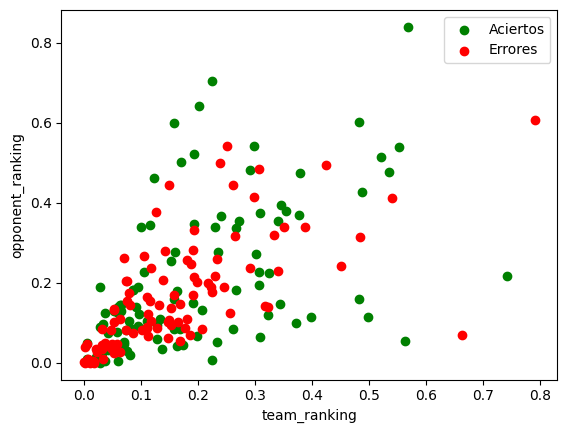

En este caso podemos ver que el modelo tiende a ser muy impreciso en la clasificación de casos donde los registros pertenecen a equipos mejor rankeados.


In [28]:
variables = ['team_ranking', 'opponent_ranking']
regression_model_plot = LogisticRegression(random_state=42, max_iter=1000)
regression_model_plot.fit(train_x_fe[variables], train_y_fe)
y_pred_fe = regression_model_plot.predict(test_x_fe[variables])

df = test_x_fe[variables].copy()
df['y_true'] = test_y_fe
df['y_pred'] = y_pred_fe

# obtenemos una muestra aleatoria de aciertos
aciertos_sample = df[df['y_true'] == df['y_pred']].sample(n=100, random_state=42)

# obtenemos una muestra aleatoria de errores
errores_sample = df[df['y_true'] != df['y_pred']].sample(n=100, random_state=42)

# Graficar los registros de la muestra aleatoria de aciertos
plt.scatter(aciertos_sample['team_ranking'], aciertos_sample['opponent_ranking'], color='green', label='Aciertos')

# Graficar los registros de la muestra aleatoria de errores
plt.scatter(errores_sample['team_ranking'], errores_sample['opponent_ranking'], color='red', label='Errores')

plt.xlabel('team_ranking')
plt.ylabel('opponent_ranking')
plt.legend()
plt.show()

print("En este caso podemos ver que el modelo tiende a ser muy impreciso en la clasificación de casos donde los registros pertenecen a equipos mejor rankeados.")

## Conclusiones:

El valor final de la métrica que podríamos informar al cliente es de un precisión en la prediccion de 58.76%, utilizando un modelo de Regresión Logística, con un feature engineering sobre los equipos a los que pertenecen los jugadores y el equipo oponente, con los parametros de regularización inversa (C) igual a 10 y una penalidad (penalty) tipo 'l2'.
Elegimos este modelo ya que el mismo además de darnos el valor de métrica mas alto, se adapta bien a problemas de clasificación binaria como el nuestro, resulta rápido a la hora de entrenar y es un modelo con alto nivel de interpretabilidad.

Por otro lado, entendemos que este valor se encuentra lejos de un valor óptimo y preciso a la hora de predecir pero si tomamos en cuenta como valor de referencia la predicción arrojada por un modelo tipo 'dummie' (49,9%), el cual se basa en suposiciones meramente estadísticas, notamos que existe una cierta mejora en la predicción utilizando estimadores mas complejos como los presentados a lo largo del trabajo.
Si bien consideramos que nuestro modelo no sería útil de implementar, quedará en manos del cliente estimar si considera necesario los costos asociados de trabajo y puesta en producción dadas las métricas obtenidas.

Respecto a las técnicas de reducción de dimensionalidad, podemos argumentar que si bien con PCA las dimensiones resultantes no denotan importancia según las estadísticas obtenidas y la presición se ve levemente afectada, el tiempo de procesamiento necesario para entrenar un modelo se ve benificiado considerablemente, por lo que si se precisa de velocidad por sobre precisión seria un método válido para aplicar.

En cuanto a la exploración de hiper-parámetros mediante búsqueda en grilla en los múltiples modelos entrenados, podemos ver que si bien encontramos conjuntos de paramétros óptimos para cada uno, los mismos no aportan aumentos significativos en la métrica de rendimiento elegida si los comparamos con los resultados obtenidos con los hiper-parámetros por defecto.

Finalmente, se aplicó feature egineering a las variables 'team' y 'opponent' de tipo string y se crearon dos features 'team_ranking' y 'opponent_ranking' de tipo float de manera que obtuvimos información medible respecto al puesto en el ranking que ocupaban los equipos el día de los partidos en el dataset. Como se puede, este re-trabajo de las variables no aporta cambios considerables en el rendimiento de predicción obtenido por lo cual no consideramos que sea razonable dedicar recursos a esta tarea (obtención de otro dataset auxiliar, tratamiento de la información, perdida de datos en el dataset original, entre otras) ya que su costo de oportunidad supera los posibles beneficios obtenidos.
Tampoco encontramos cambios significativos en los resultados si utilizamos el dataset extra creado sin el encoding de paises.

En conclusión, podemos aseverar que luego de realizado el tratamiento del dataset original mediante técnicas de preprocesamiento y feature engineering, y habiendo aplicado variadas técnicas de machine learning en pos de obtener luego predicciones acerca de partidos futuros, no obtuvimos los resultados esperados, ya sea porque la variables disponibles no son de relevancia para predecir la variable de salida o que las variables descartadas del dataset original puedan tener mayor correlacion en pos de aumentar la precisión de nuestro modelo.